# Data Exploration on Ford GoBike Data
## in San Francisco Bay Area
### by Reinhold Mauch

## Investigation Overview

This presentation gives insights on usage patterns of __bycyle rides__ of the  
__Ford GoBike bike sharing system__ (now known as Bay Wheels)  
located in the San Francisco Bay Area on the West Coast of the United States.  

All upcoming insights are based on a given dataset of bike rides.  
The objective was to identify __patterns__ and __dependencies__ within the dataset.  
  
I'm going to answer following questions:  
1. What is the mean and distribution of ride duration?
2. Who is the typical user of the bike share system?
3. What is the typical usage pattern for the bike system?
4. Where do rides start and where do they end?
5. Conclusion

## Dataset Overview

All insights are based on a dataset of bike rides within the __San Francisco Bay Area__ in __February 2019__.  
The original dataset contained __183.412__ individual bike rides with following information:
* anonymized user data (birth year, membership, gender, enrollment of user in "Bike Share For All Program" for residents with low income)
* bike share station information of around 330 bike stations (id, address, geo-position)
* ride data (start time, end time, start station, end station, ride duration)

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
bike_rentals_clean = pd.read_csv('./ford_gobike_clean.csv')
# convert member_gender, ride_type_daytime, user_type, weekday_start, weekday_end into categorical types

bike_rentals_clean['start_time'] = pd.to_datetime(bike_rentals_clean['start_time'])
bike_rentals_clean['end_time'] = pd.to_datetime(bike_rentals_clean['end_time'])

ordinal_var_dict = {'member_gender': ['Male','Female','Other'],
                    'ride_type_daytime': ['morning','mid-day','afternoon', 'evening', 'night'],
                    'weekday_start': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                    'age_level': ['<20','20s','30s','40s','50+'],
                    'ride_type_duration': ['short','long'],
                   'user_type': ['Subscriber', 'Customer']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var_dict[var])
    bike_rentals_clean[var] = bike_rentals_clean[var].astype(ordered_var)
    
#add new category weekend, weekdays
bike_rentals_clean['part_of_week'] = bike_rentals_clean.apply(
    lambda x: ("weekend" if (x.weekday_start in ['Saturday', 'Sunday']) else 'weekdays'), axis = 1)
bike_rentals_clean.part_of_week.value_counts()

#create new categories for location, location_end
bins=[-122.5 , -122.35, -122.05, -121.8]
location_labels=['San Francisco', 'Oakland','San Jose']
bike_rentals_clean['location']=pd.cut(x=bike_rentals_clean['start_station_longitude'],bins=bins,labels=location_labels)
bike_rentals_clean['location_end']=pd.cut(x=bike_rentals_clean['end_station_longitude'],bins=bins,labels=location_labels)

#Since I will try to distinguish between location data later I decide to drop those entries
bike_rentals_clean = bike_rentals_clean[bike_rentals_clean.location == bike_rentals_clean.location_end]
#drop end column
bike_rentals_clean.drop(columns=['location_end'], inplace=True)

## 1. What is the mean and distribution of ride duration?

First things first: Let's get a picture of a typical bycicle ride in the dataset

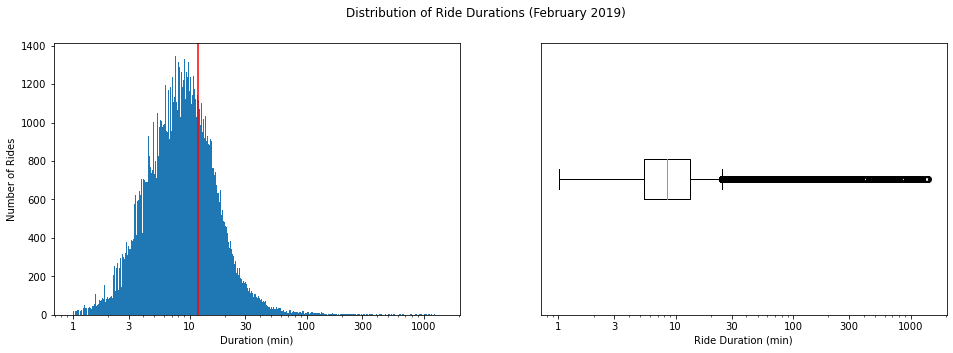

In [3]:
plt.figure(figsize=[16, 5])

ax = plt.subplot(1, 2, 1)
log_binsize = 0.005
log_bins = 10 ** np.arange(-0.005, np.log10(bike_rentals_clean['duration_min'].max()) + log_binsize, log_binsize)

plt.hist(data = bike_rentals_clean, x = 'duration_min', bins = log_bins)
plt.xlabel('Duration (min)')
plt.ylabel('Number of Rides')
plt.xscale('log')
xticks = [1, 3, 10, 30, 100, 300, 1000]
plt.xticks(xticks, xticks)
plt.axvline(bike_rentals_clean.duration_min.mean(), color  = 'red')

ax = plt.subplot(1, 2, 2)
xticks = [1, 3, 10, 30, 100, 300, 1000]
plt.xscale('log')
ax.axes.get_yaxis().set_visible(False)
plt.xticks(xticks, xticks)
plt.boxplot(bike_rentals_clean['duration_min'], vert=False )
plt.xlabel("Ride Duration (min)");
plt.suptitle('Distribution of Ride Durations (February 2019)')
plt.show()

* We see a typical ride duration between __5__ and __20__ minutes with a mean duration of around __12__ minutes.

* Ignoring extremely long rides (identified as outliers in box plot) reduces the mean ride time to around __9__ min.

## 2. Who is the typical user of the bike share system?

Let's have a look at age, gender and the user type information in the dataset.

In [4]:
df = bike_rentals_clean.groupby('age_level').size().reset_index().rename(columns={0:'counts'})
#df = df.reindex([4,0,1,2,3])
user_count = df.counts.sum()
df['proportion'] = df.apply(lambda x: x.counts/user_count, axis=1)
df

,age_level,counts,proportion
0,<20,4213,0.024092
1,20s,70051,0.400587
2,30s,63805,0.364869
3,40s,22021,0.125927
4,50+,14781,0.084525


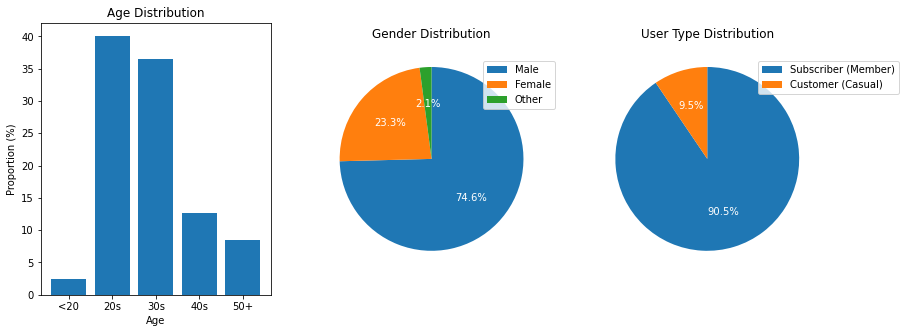

In [5]:
plt.figure(figsize=(14, 5))
base_color = sb.color_palette()[0]
ticks = np.arange(0.00, 0.45, 0.05)
labels = (ticks * 100).astype(int)
ax = plt.subplot(1, 3, 1)
plt.bar(data=df, x='age_level', height='proportion')
#sb.countplot(data = bike_rentals_clean, x = 'age_level', color = base_color, ax = ax)
plt.title('Age Distribution')
ax.set_yticks(ticks)
ax.set_yticklabels(labels)
ax.set_ylabel('Proportion (%)')
ax.set_xlabel('Age')

ax = plt.subplot(1, 3, 2)
sorted_counts = bike_rentals_clean['member_gender'].value_counts()
my_index = sorted_counts.index
wedges, texts, autotexts = plt.pie(sorted_counts, labels = my_index, startangle = 90, counterclock = False, autopct = '%1.1f%%', textprops=dict(color="w"));
plt.title('Gender Distribution')
ax.legend(wedges, my_index,
          loc="upper left",
          bbox_to_anchor=(0.7, 0, 1, 0.95))

ax = plt.subplot(1, 3, 3)
sorted_counts = bike_rentals_clean['user_type'].value_counts()
my_index = ['Subscriber (Member)', 'Customer (Casual)']
wedges, texts, autotexts = plt.pie(sorted_counts, labels = my_index, startangle = 90, counterclock = False, autopct = '%1.1f%%', textprops=dict(color="w"));
plt.title('User Type Distribution')
ax.legend(wedges, my_index,
          loc="upper left",
          bbox_to_anchor=(0.7, 0, 1, 0.95))

plt.show()

* Our typical user is in his __20s__ or __30s__.

* Around __75%__ of users are male, __23%__ female and __2%__ other gender.

* Only around __10%__ of users are sporadic users, __90%__ are subsribers

## 3. What is the typical usage pattern for the bike system?

Let's have a look on the usage of bikes throughout the day during the week and on weekends.

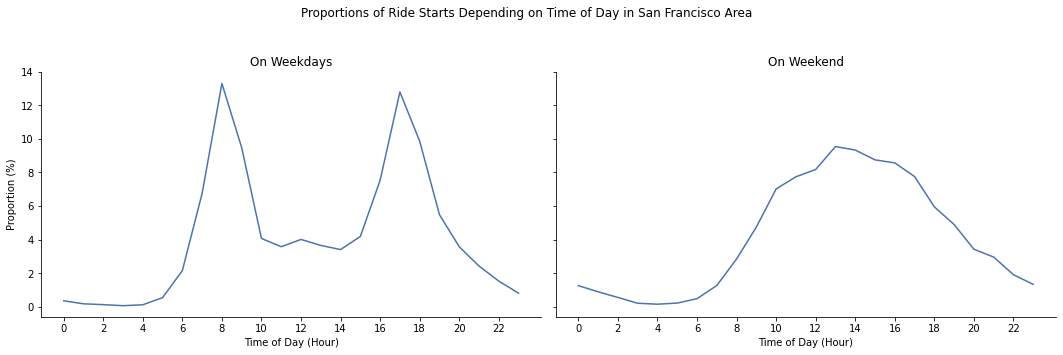

In [6]:
#get values by hour
plot_data = bike_rentals_clean[bike_rentals_clean['location'] == "San Francisco"]

start_hour_counts = bike_rentals_clean.groupby(['part_of_week', 'hour_start']).size().reset_index().rename(columns = {0 : 'counts'})
#get proportions instead of counts
start_hour_counts_totals = start_hour_counts.groupby(['part_of_week'])['counts'].sum()
start_hour_counts['proportion'] = start_hour_counts.apply(lambda x: (x.counts / start_hour_counts_totals[x.part_of_week]), axis = 1)

sb.set_palette('deep')
base_color = sb.color_palette()[0]

g = sb.FacetGrid(data=start_hour_counts, col='part_of_week', height=5, aspect = 1.5, margin_titles = True)
g = g.map(sb.lineplot,'hour_start', 'proportion', color=base_color)

g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Proportions of Ride Starts Depending on Time of Day in San Francisco Area');
xticks = np.arange(0, 23, 2)
yticks = np.arange(0.00, 0.15, 0.02)
ylabels = (yticks * 100).astype(int)
subplot_titles = ['On Weekdays', 'On Weekend']

for i, ax in enumerate(g.axes.flatten()):
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    title =ax.get_title()
    ax.set_title(subplot_titles[i])
    ax.set_xlabel('Time of Day (Hour)')
    ax.set_ylabel('Proportion (%)')
    i+=1
    

* We see two distinct usage peaks in the __morning__ and __afternoon during the week__.

* On __weekends__ there is a completely different usage pattern. Now we have __only one peak in the afternoon__.

## 4.1 Where do ride start and where do they end?

Now we're going to have a look at our bike stations. Where do rides start/end in the morning

In [7]:
#getting bins based on descriptive statistics of field
def getStandardBins(df, col):
    desc_stat = df[col].describe()
    return [desc_stat['min']-1, desc_stat['25%'], desc_stat['50%'], desc_stat['75%'], desc_stat['max']] 

# calculating the data to be plotted
ride_cat_labels = ['<25%', '25-50%', '50-75%', '>75%']

plot_data = bike_rentals_clean[(bike_rentals_clean.location == 'San Francisco') & (bike_rentals_clean.part_of_week == 'weekdays')]

plot_data_start = plot_data.groupby(['ride_type_daytime',
                               'start_station_longitude',
                               'start_station_latitude']).size().reset_index().rename(columns={0:'counts'})
plot_data_start = plot_data_start[plot_data_start.counts > 0]
plot_data_start['ride_frequency'] = pd.cut(plot_data_start['counts'], bins = getStandardBins(plot_data_start, 'counts'), labels = ride_cat_labels)
plot_data_start['station_type'] = "start_station"
plot_data_start.rename(columns={'start_station_longitude':'station_longitude', 'start_station_latitude':'station_latitude'}, inplace=True)

plot_data_end = plot_data.groupby(['ride_type_daytime',
                                 'end_station_longitude',
                                 'end_station_latitude']).size().reset_index().rename(columns={0:'counts'})
plot_data_end = plot_data_end[plot_data_end.counts > 0]
plot_data_end['ride_frequency'] = pd.cut(plot_data_end['counts'], bins = getStandardBins(plot_data_end, 'counts'), labels = ride_cat_labels)
plot_data_end['station_type'] = "end_station"
plot_data_end.rename(columns={'end_station_longitude':'station_longitude', 'end_station_latitude':'station_latitude'}, inplace=True);


plot_data_concat = plot_data_start.append(plot_data_end)

station_info_counts_totals = plot_data_concat.groupby(['station_latitude', 'station_longitude'])['counts'].sum()
plot_data_concat['proportion'] = plot_data_concat.apply(lambda x: (x.counts /
                            station_info_counts_totals[x.station_latitude]
                            [x.station_longitude]), axis = 1)
#re-calculate ridefrequency based on proportions
plot_data_concat['ride_frequency_on_proportions'] = pd.cut(plot_data_concat['proportion'], bins = len(ride_cat_labels), labels = ride_cat_labels)

plot_1_plot_data = plot_data_concat[plot_data_concat.ride_type_daytime == 'morning']
plot_2_plot_data = plot_data_concat[plot_data_concat.ride_type_daytime == 'afternoon']



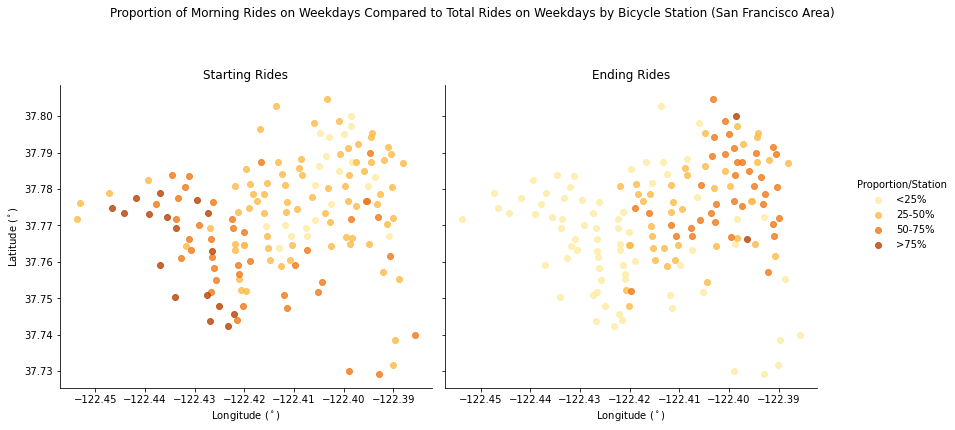

In [10]:
g = sb.FacetGrid(data=plot_1_plot_data, col='station_type', hue ='ride_frequency_on_proportions', 
                 height=6, aspect = 1, margin_titles = True, palette = 'YlOrBr')
sb.set_palette('Reds')
g = g.map(sb.regplot,'station_longitude', 'station_latitude', fit_reg = False)

g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Proportion of Morning Rides on Weekdays Compared to Total Rides on Weekdays by Bicycle Station (San Francisco Area)');
g.add_legend(title='Proportion/Station')

subplot_titles = ['Starting Rides', 'Ending Rides']

for i, ax in enumerate(g.axes.flatten()):
    
    ax.set_title(subplot_titles[i])
    ax.set_xlabel('Longitude ($^\circ$)')
    if i == 0:
        ax.set_ylabel('Latitude ($^\circ$)')


* Stations in the __South/West__ show high proportions of __ride starts in the morning__

* Stations in the __North/East__ show high proportions of __ride ends in the morning__

## 4.2 Where do rides start and where do they end?

We've learned that there is some sort of movement going on in the morning. What about the afternoon?

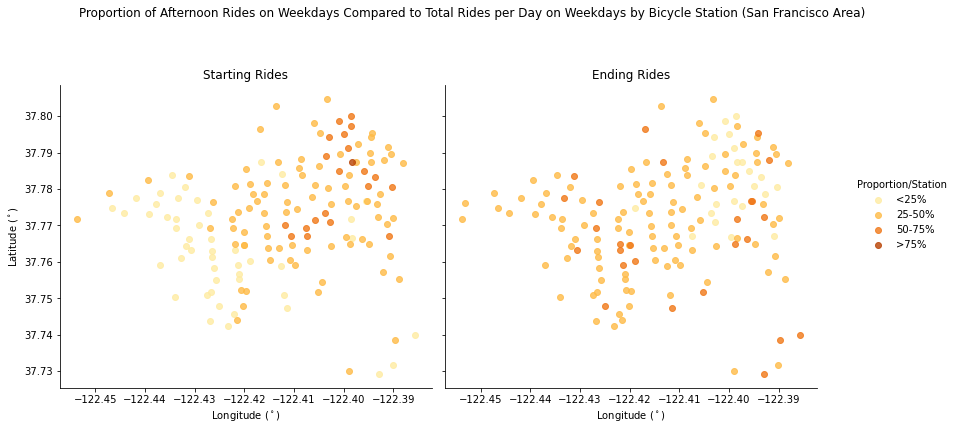

In [9]:
g = sb.FacetGrid(data=plot_2_plot_data, col='station_type', hue ='ride_frequency_on_proportions', 
                 height=6, aspect = 1, margin_titles = True, palette = 'YlOrBr')
sb.set_palette('Reds')
g = g.map(sb.regplot,'station_longitude', 'station_latitude', fit_reg = False)

g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Proportion of Afternoon Rides on Weekdays Compared to Total Rides per Day on Weekdays by Bicycle Station (San Francisco Area)');
g.add_legend(title='Proportion/Station')

subplot_titles = ['Starting Rides', 'Ending Rides']

for i, ax in enumerate(g.axes.flatten()):    
    ax.set_title(subplot_titles[i])
    ax.set_xlabel('Longitude ($^\circ$)')
    if i == 0:
        ax.set_ylabel('Latitude ($^\circ$)')

* In the __afternoon__ stations in the __North/East__ show high proportions of __ride starts__ and all stations in the __Western part__ show higher proportions of __ride ends__ 

* In the __afternoon__ this time the direction seems to be __more spread__ but still the __trend is visible__.

## 5. Conclusion

Adding all insights up the dataset indicates a commuter pattern:
* Short rides instead of long rides
* High number of subscribers
* Usage peaks on typical work start and work end hours during the week.
* Completely different pattern on weekends
* Defined direction of travel on usage peaks